In [1]:
#import packages and CH4 files

import pandas as pd
import numpy as np
import os
import openpyxl


#DF CH4 Import

if os.name == 'nt':
    df_file = "E:/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/DF CH4.xlsx"
elif os.name == 'posix':
    df_file = "/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/DF CH4.xlsx"

df_ch4 = pd.read_excel(df_file, comment="#", skiprows=19, sheet_name=5, usecols=[0,1], names=["depth (m)", "CH4 (ppb)"])

df_ch4.dropna(inplace=True)

#EDC CH4 Import

if os.name == 'nt':
    edc_file = "E:/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/EDC CH4.xlsx"
elif os.name == 'posix':
    edc_file = "/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/EDC CH4.xlsx"

edc_ch4 = pd.read_excel(edc_file, comment="#", skiprows=1, sheet_name=0, names=["depth (m)", "Gas age (a bp)", "CH4 (ppb)", "uncertainty"])

edc_ch4.dropna(inplace=True)

#EDML CH4 Import

if os.name == 'nt':
    edml_file = "E:/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/EDML CH4.tab"
elif os.name == 'posix':
    edml_file = "/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/EDML CH4.tab"

edml_ch4 = pd.read_csv(edml_file, delimiter="\t", comment="#", names=["depth (m)", "Gas age (a bp)", "CH4 (ppb)"])

edml_ch4.dropna(inplace=True)

edml_ch4["Gas age (a bp)"] = edml_ch4["Gas age (a bp)"]*1000

#WDC CH4 Import

if os.name == 'nt':
    wdc_file = "E:/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/WDC CH4.txt"
elif os.name == 'posix':
    wdc_file = "/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono/BICC2025/raw data/Methane Data/WDC CH4.txt"

wdc_ch4 = pd.read_csv(wdc_file, delimiter="\t", comment="#", names=["depth (m)", "Gas age (a bp)", "CH4 (ppb)", "lab"])

wdc_ch4.dropna(inplace=True)

wdc_ch4 = pd.DataFrame({
    "depth (m)": wdc_ch4["depth (m)"],
    "Gas age (a bp)": wdc_ch4["Gas age (a bp)"],
    "CH4 (ppb)": wdc_ch4["CH4 (ppb)"]

})

In [2]:
#import core output files

cores = ['DF', 'EDC', 'EDML', 'WDC']
core_ch4 = [df_ch4, edc_ch4, edml_ch4, wdc_ch4]

paleo_output = {}

for core in cores:
    if os.name == 'nt':
        core_df_path = f"E:/GitHub/BICC/Paleochrono/BICC2025/{core}/output.txt"
    elif os.name == 'posix':
        core_df_path = f"/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono/BICC2025/{core}/output.txt"
    core_df = pd.read_csv(core_df_path, delimiter="\t", comment="#", names=["depth", "ice_age", "sigma_ice_age", "air_age", "sigma_air_age", "sigma_delta_age", "deporate", "sigma_deporate", "thinning", "sigma_thinning", "LID", "sigma_LID", "delta_depth", "sigma_delta_depth", "deporate_model", "sigma_deporate_model", "thinning_model", "sigma_thinning_model", "LID_model", "sigma_LID_model", "icelayerthick", "sigma_icelayerthick", "airlayerthick", "sigma_airlayerthick"])
    
    core_df = pd.DataFrame({
    "depth": core_df["depth"],
    "air_age": core_df["air_age"],
    })

    core_df.dropna(inplace=True)
    
    paleo_output[core] = core_df


In [3]:
ch4_df = {}

#this is temp fix because DF doesn't have gas age
core_ch4 = [df_ch4, edc_ch4, edml_ch4, wdc_ch4]

for core, core_data in zip(cores, core_ch4):
    paleo_depth_age = pd.DataFrame({
        "depth": paleo_output[core]['depth'],
        "air_age": paleo_output[core]['air_age']
    })

    lab_ch4 = pd.DataFrame({
        "depth (m)": core_data["depth (m)"],
        "ch4_ppb": core_data["CH4 (ppb)"]
    })

    interpolated_age = np.interp(lab_ch4["depth (m)"], paleo_depth_age["depth"], paleo_depth_age["air_age"])

    ch4_df[core] = pd.DataFrame({
        "gas_age (a bp)": interpolated_age,
        "depth (m)": lab_ch4["depth (m)"],
        "ch4_ppb": lab_ch4["ch4_ppb"]
    })


In [4]:
#This shows each core methane vs gas age

import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))

# Plot data for each core
for core in ch4_df:
    plt.plot(
        ch4_df[core]["gas_age (a bp)"], 
        ch4_df[core]["ch4_ppb"], 
        label=core,
        alpha=1
    )

# Add labels and title
plt.xlabel("Gas Age (a BP)")
plt.ylabel("CH₄ Concentration (ppb)")
plt.title("CH₄ Concentration vs. Gas Age for Ice Cores")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.ylim(250, 1000)
plt.xlim(0, 50000)

# Show the plot
#plt.savefig("E:/GitHub/BICC/Paleochrono/BICC2025/CH4_concentration_vs_gas_age.png")
plt.show()

In [5]:
#Offsetted to compare lines
import copy

#max age set
max_age_ka = 200

# Create a plot
plt.figure(figsize=(10, 6))

#offset
x=0
ch4_df_offset = copy.deepcopy(ch4_df)
for core in ch4_df_offset:
    ch4_df_offset[core]["ch4_ppb"] = ch4_df_offset[core]["ch4_ppb"] + x
    x+=125

# Plot data for each core
for core in ch4_df_offset:
    plt.plot(
        ch4_df_offset[core]["gas_age (a bp)"], 
        ch4_df_offset[core]["ch4_ppb"], 
        label=core,
        alpha=1
    )

# Add labels and title
plt.xlabel("Gas Age (a BP)")
plt.ylabel("CH₄ Concentration")
plt.gca().set_yticks([])  # Removes ticks and numbers from y-axis
plt.title("CH₄ Concentration vs. Gas Age for Ice Cores")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.ylim(250, 1200)
plt.xlim(0, max_age_ka*1000)

# Show the plot
#plt.savefig("E:/GitHub/BICC/Paleochrono/BICC2025/stacked_ch4_gas_age.png")
plt.show()

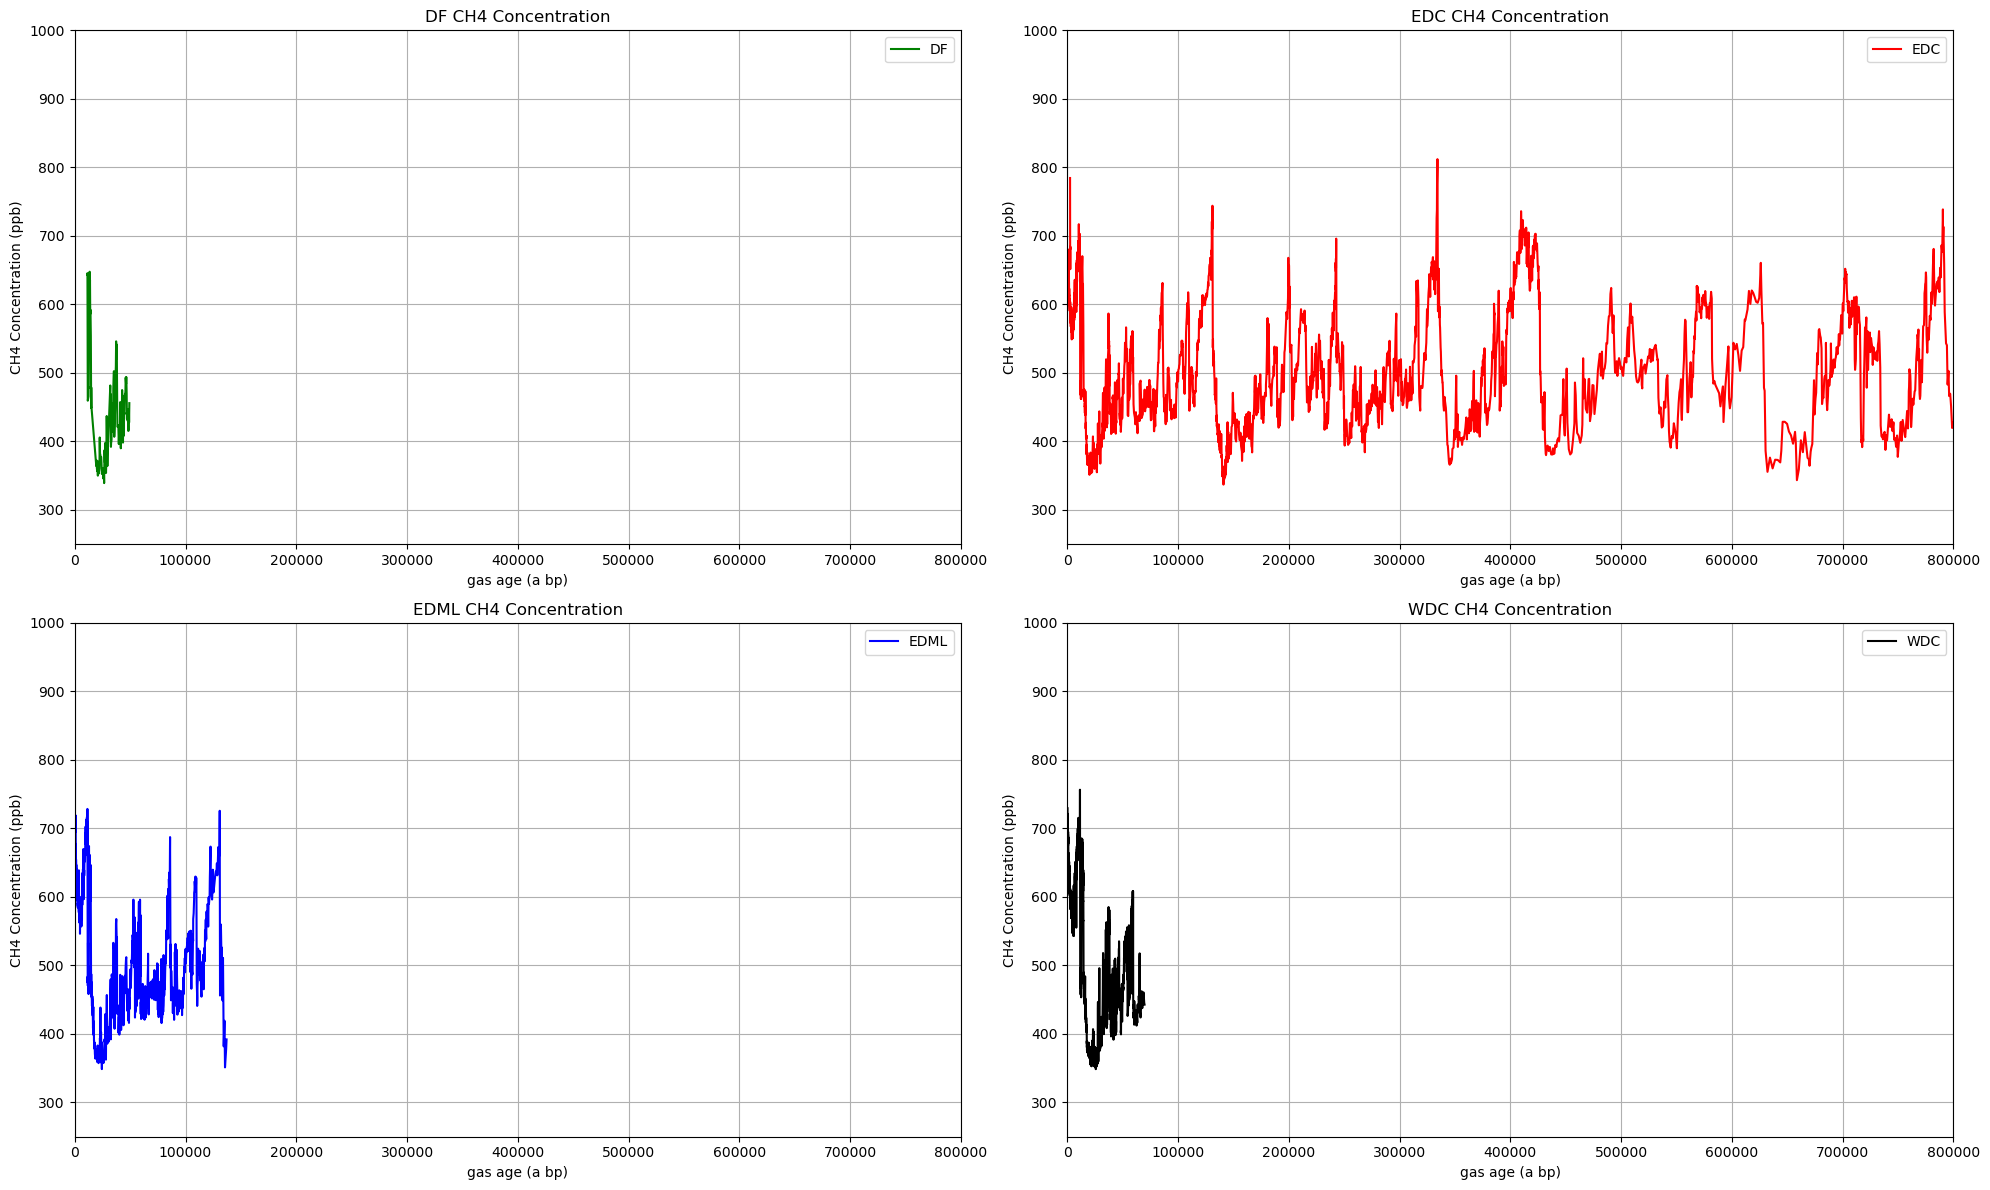

In [6]:
import matplotlib.pyplot as plt

#max age ago
max_age_ka = 800

#number of cores
num_cores = len(ch4_df)
cols = 2
rows = (num_cores + 1) // cols

# Generate distinct colors using a colormap
colors = ['green', 'red', 'blue', 'black']

#create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))
axes = axes.flatten()  # Flatten in case it's a 2D array

# Plot data for each core
for i, core in enumerate(ch4_df):
    ax = axes[i]
    ax.plot(
        ch4_df[core]["gas_age (a bp)"], 
        ch4_df[core]["ch4_ppb"], 
        label=core,
        color = colors[i]
    )
    ax.set_xlabel("gas age (a bp)")
    ax.set_ylabel("CH4 Concentration (ppb)")
    ax.set_title(f"{core} CH4 Concentration")
    ax.set_ylim(250, 1000)
    ax.grid(True)
    ax.legend()
    ax.set_xlim(0, max_age_ka*1000)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
#plt.savefig("E:/GitHub/BICC/Paleochrono/BICC2025/CH4_concentration_vs_gas age_subplots.png")
plt.show()

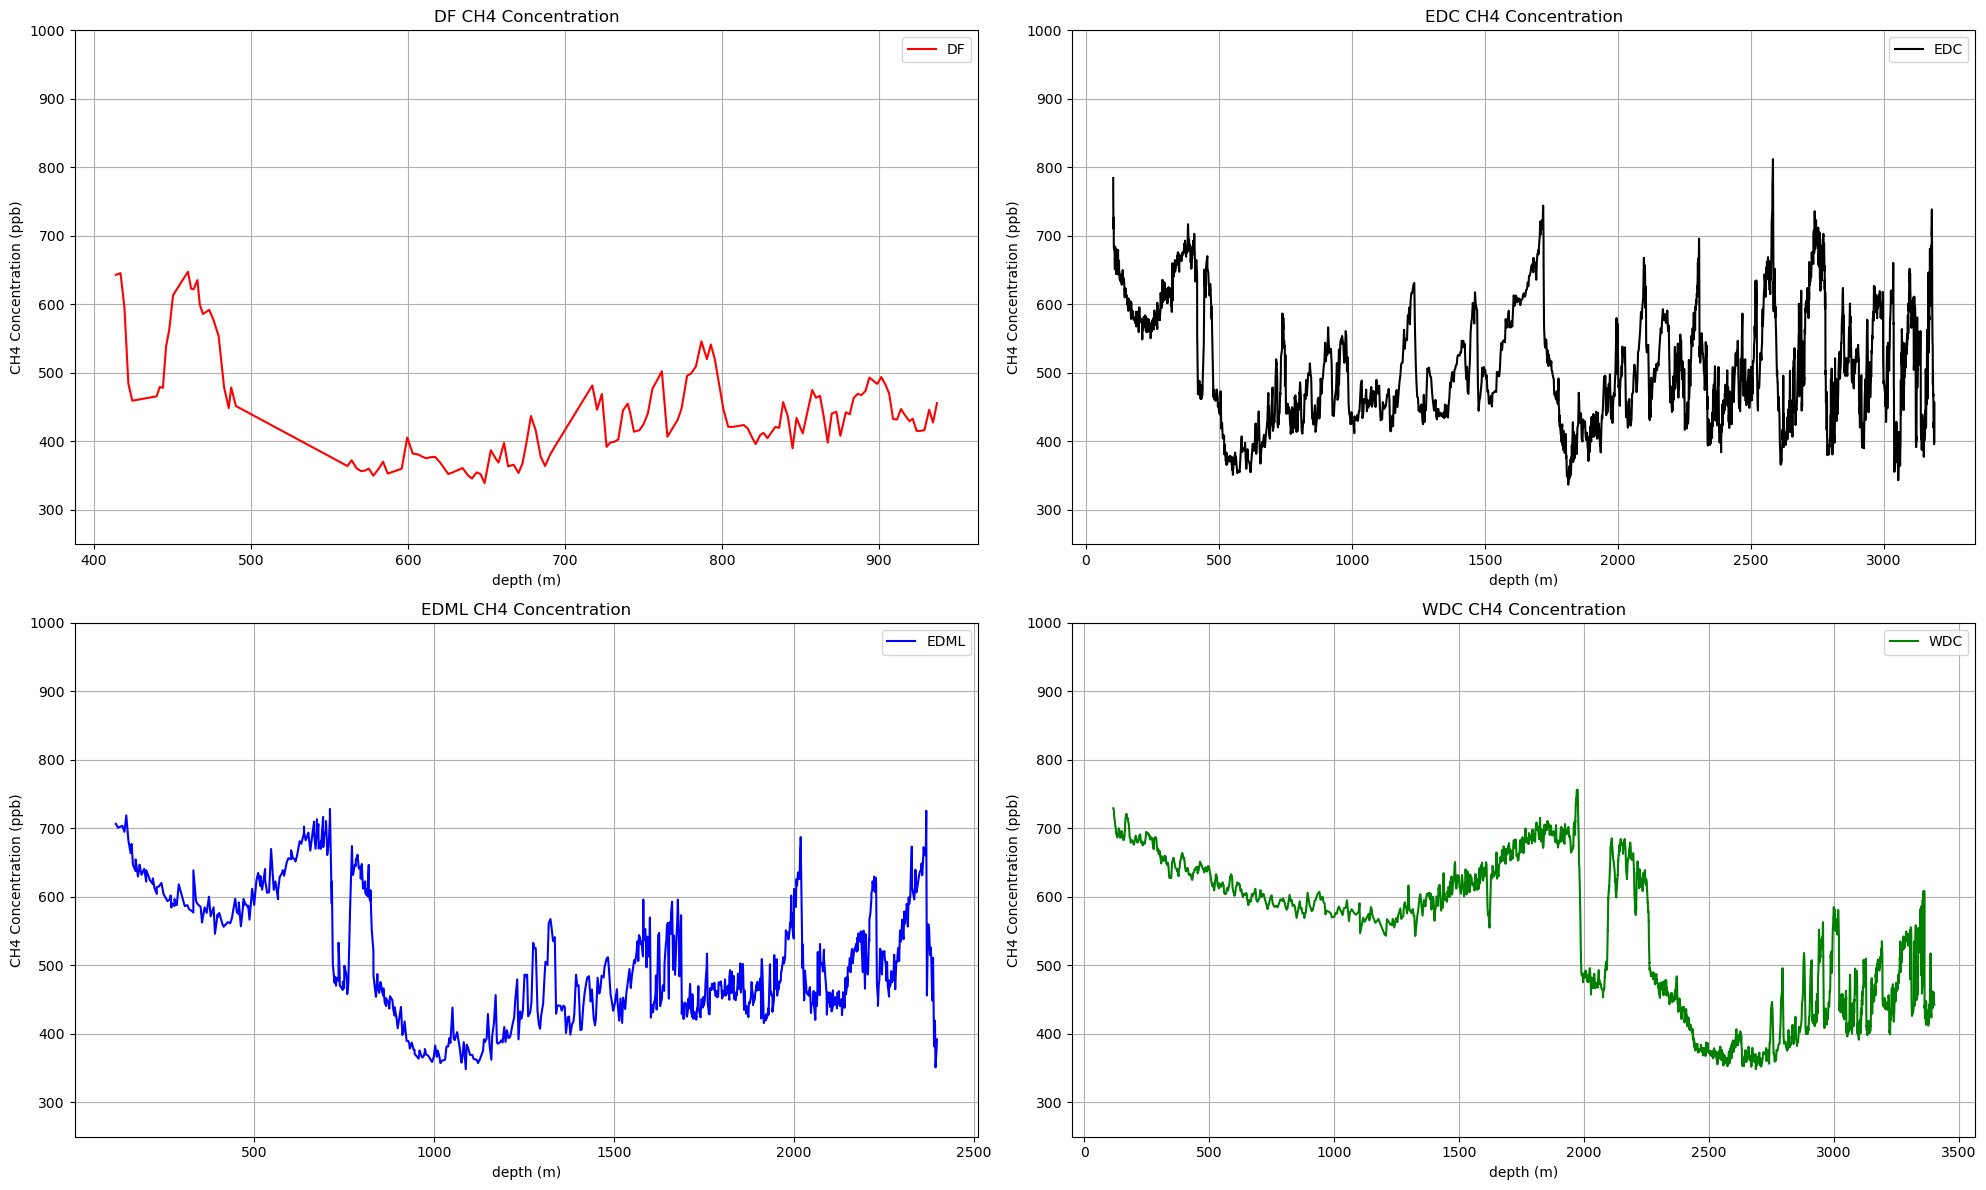

In [7]:
import matplotlib.pyplot as plt

#number of cores
num_cores = len(ch4_df)
cols = 2
rows = (num_cores + 1) // cols

# Generate distinct colors using a colormap
colors = ['red', 'black', 'blue', 'green']

#create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))
axes = axes.flatten()  # Flatten in case it's a 2D array

# Plot data for each core
for i, core in enumerate(ch4_df):
    ax = axes[i]
    ax.plot(
        ch4_df[core]["depth (m)"],
        ch4_df[core]["ch4_ppb"],
        label=core,
        color = colors[i]
    )
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("CH4 Concentration (ppb)")
    ax.set_title(f"{core} CH4 Concentration")
    ax.set_ylim(250, 1000)
    ax.grid(True)
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
#plt.savefig("E:/GitHub/BICC/Paleochrono/BICC2025/CH4_concentration_vs_depth_subplots.png")
plt.show()